<a href="https://colab.research.google.com/github/mehal99/Personalized-Federated-Learning/blob/main/pFedHN_PC_reproduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Datasets and related utilities

In [ ]:
import random
from collections import defaultdict

import numpy as np
import torch.utils.data
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, CIFAR100


def get_datasets(data_name, dataroot, normalize=True, val_size=10000):
    """
    get_datasets returns train/val/test data splits of CIFAR10/100 datasets
    :param data_name: name of dataset, choose from [cifar10, cifar100]
    :param dataroot: root to data dir
    :param normalize: True/False to normalize the data
    :param val_size: validation split size (in #samples)
    :return: train_set, val_set, test_set (tuple of pytorch dataset/subset)
    """

    if data_name =='cifar10':
        normalization = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        data_obj = CIFAR10
    elif data_name == 'cifar100':
        normalization = transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
        data_obj = CIFAR100
    else:
        raise ValueError("choose data_name from ['mnist', 'cifar10', 'cifar100']")

    trans = [transforms.ToTensor()]

    if normalize:
        trans.append(normalization)

    transform = transforms.Compose(trans)

    dataset = data_obj(
        dataroot,
        train=True,
        download=True,
        transform=transform
    )

    test_set = data_obj(
        dataroot,
        train=False,
        download=True,
        transform=transform
    )

    train_size = len(dataset) - val_size
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

    return train_set, val_set, test_set


def get_num_classes_samples(dataset):
    """
    extracts info about certain dataset
    :param dataset: pytorch dataset object
    :return: dataset info number of classes, number of samples, list of labels
    """
    # ---------------#
    # Extract labels #
    # ---------------#
    if isinstance(dataset, torch.utils.data.Subset):
        if isinstance(dataset.dataset.targets, list):
            data_labels_list = np.array(dataset.dataset.targets)[dataset.indices]
        else:
            data_labels_list = dataset.dataset.targets[dataset.indices]
    else:
        if isinstance(dataset.targets, list):
            data_labels_list = np.array(dataset.targets)
        else:
            data_labels_list = dataset.targets
    classes, num_samples = np.unique(data_labels_list, return_counts=True)
    num_classes = len(classes)
    return num_classes, num_samples, data_labels_list


def gen_classes_per_node(dataset, num_users, classes_per_user=2, high_prob=0.6, low_prob=0.4):
    """
    creates the data distribution of each client
    :param dataset: pytorch dataset object
    :param num_users: number of clients
    :param classes_per_user: number of classes assigned to each client
    :param high_prob: highest prob sampled
    :param low_prob: lowest prob sampled
    :return: dictionary mapping between classes and proportions, each entry refers to other client
    """
    num_classes, num_samples, _ = get_num_classes_samples(dataset)

    # -------------------------------------------#
    # Divide classes + num samples for each user #
    # -------------------------------------------#
    # assert (classes_per_user * num_users) % num_classes == 0, "equal classes appearance is needed"
    count_per_class = (classes_per_user * num_users) // num_classes + 1
    class_dict = {}
    for i in range(num_classes):
        # sampling alpha_i_c
        probs = np.random.uniform(low_prob, high_prob, size=count_per_class)
        # normalizing
        probs_norm = (probs / probs.sum()).tolist()
        class_dict[i] = {'count': count_per_class, 'prob': probs_norm}

    # -------------------------------------#
    # Assign each client with data indexes #
    # -------------------------------------#
    class_partitions = defaultdict(list)
    for i in range(num_users):
        c = []
        for _ in range(classes_per_user):
            class_counts = [class_dict[i]['count'] for i in range(num_classes)]
            max_class_counts = np.where(np.array(class_counts) == max(class_counts))[0]
            c.append(np.random.choice(max_class_counts))
            class_dict[c[-1]]['count'] -= 1
        class_partitions['class'].append(c)
        class_partitions['prob'].append([class_dict[i]['prob'].pop() for i in c])
    return class_partitions


def gen_data_split(dataset, num_users, class_partitions):
    """
    divide data indexes for each client based on class_partition
    :param dataset: pytorch dataset object (train/val/test)
    :param num_users: number of clients
    :param class_partitions: proportion of classes per client
    :return: dictionary mapping client to its indexes
    """
    num_classes, num_samples, data_labels_list = get_num_classes_samples(dataset)

    # -------------------------- #
    # Create class index mapping #
    # -------------------------- #
    data_class_idx = {i: np.where(data_labels_list == i)[0] for i in range(num_classes)}

    # --------- #
    # Shuffling #
    # --------- #
    for data_idx in data_class_idx.values():
        random.shuffle(data_idx)

    # ------------------------------ #
    # Assigning samples to each user #
    # ------------------------------ #
    user_data_idx = [[] for i in range(num_users)]
    for usr_i in range(num_users):
        for c, p in zip(class_partitions['class'][usr_i], class_partitions['prob'][usr_i]):
            end_idx = int(num_samples[c] * p)
            user_data_idx[usr_i].extend(data_class_idx[c][:end_idx])
            data_class_idx[c] = data_class_idx[c][end_idx:]

    return user_data_idx


def gen_random_loaders(data_name, data_path, num_users, bz, classes_per_user):
    """
    generates train/val/test loaders of each client
    :param data_name: name of dataset, choose from [cifar10, cifar100]
    :param data_path: root path for data dir
    :param num_users: number of clients
    :param bz: batch size
    :param classes_per_user: number of classes assigned to each client
    :return: train/val/test loaders of each client, list of pytorch dataloaders
    """
    loader_params = {"batch_size": bz, "shuffle": False, "pin_memory": True, "num_workers": 0}
    dataloaders = []
    datasets = get_datasets(data_name, data_path, normalize=True)
    for i, d in enumerate(datasets):
        # ensure same partition for train/test/val
        if i == 0:
            cls_partitions = gen_classes_per_node(d, num_users, classes_per_user)
            loader_params['shuffle'] = True
        usr_subset_idx = gen_data_split(d, num_users, cls_partitions)
        # create subsets for each client
        subsets = list(map(lambda x: torch.utils.data.Subset(d, x), usr_subset_idx))
        # create dataloaders from subsets
        dataloaders.append(list(map(lambda x: torch.utils.data.DataLoader(x, **loader_params), subsets)))

    return dataloaders

## Utils

In [ ]:
import argparse
import logging
import random

import numpy as np
import torch


def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')


def set_logger():
    logging.basicConfig(
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        level=logging.INFO
    )


def set_seed(seed):
    """for reproducibility
    :param seed:
    :return:
    """
    np.random.seed(seed)
    random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def get_device(no_cuda=False, gpus='0'):
    return torch.device(f"cuda:{gpus}" if torch.cuda.is_available() and not no_cuda else "cpu")

## Models

In [ ]:
import torch.nn.functional as F
from torch import nn
from torch.nn.utils import spectral_norm


class LocalLayer(nn.Module):

    def __init__(self, n_input=84, n_output=2, nonlinearity=False):
        super().__init__()
        self.nonlinearity = nonlinearity
        layers = []
        if nonlinearity:
            layers.append(nn.ReLU())

        layers.append(nn.Linear(n_input, n_output))
        self.layer = nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class CNNHyperPC(nn.Module):
    def __init__(
            self, n_nodes, embedding_dim, in_channels=3, out_dim=10, n_kernels=16, hidden_dim=100,
            spec_norm=False, n_hidden=1):
        super().__init__()

        self.in_channels = in_channels
        self.out_dim = out_dim
        self.n_kernels = n_kernels
        self.embeddings = nn.Embedding(num_embeddings=n_nodes, embedding_dim=embedding_dim)

        layers = [
            spectral_norm(nn.Linear(embedding_dim, hidden_dim)) if spec_norm else nn.Linear(embedding_dim, hidden_dim),
        ]
        for _ in range(n_hidden):
            layers.append(nn.ReLU(inplace=True))
            layers.append(
                spectral_norm(nn.Linear(hidden_dim, hidden_dim)) if spec_norm else nn.Linear(hidden_dim, hidden_dim),
            )

        self.mlp = nn.Sequential(*layers)

        self.c1_weights = nn.Linear(hidden_dim, self.n_kernels * self.in_channels * 5 * 5)
        self.c1_bias = nn.Linear(hidden_dim, self.n_kernels)
        self.c2_weights = nn.Linear(hidden_dim, 2 * self.n_kernels * self.n_kernels * 5 * 5)
        self.c2_bias = nn.Linear(hidden_dim, 2 * self.n_kernels)
        self.l1_weights = nn.Linear(hidden_dim, 120 * 2 * self.n_kernels * 5 * 5)
        self.l1_bias = nn.Linear(hidden_dim, 120)
        self.l2_weights = nn.Linear(hidden_dim, 84 * 120)
        self.l2_bias = nn.Linear(hidden_dim, 84)

        if spec_norm:
            self.c1_weights = spectral_norm(self.c1_weights)
            self.c1_bias = spectral_norm(self.c1_bias)
            self.c2_weights = spectral_norm(self.c2_weights)
            self.c2_bias = spectral_norm(self.c2_bias)
            self.l1_weights = spectral_norm(self.l1_weights)
            self.l1_bias = spectral_norm(self.l1_bias)
            self.l2_weights = spectral_norm(self.l2_weights)
            self.l2_bias = spectral_norm(self.l2_bias)

    def forward(self, idx):
        emd = self.embeddings(idx)
        features = self.mlp(emd)

        weights = {
            "conv1.weight": self.c1_weights(features).view(self.n_kernels, self.in_channels, 5, 5),
            "conv1.bias": self.c1_bias(features).view(-1),
            "conv2.weight": self.c2_weights(features).view(2 * self.n_kernels, self.n_kernels, 5, 5),
            "conv2.bias": self.c2_bias(features).view(-1),
            "fc1.weight": self.l1_weights(features).view(120, 2 * self.n_kernels * 5 * 5),
            "fc1.bias": self.l1_bias(features).view(-1),
            "fc2.weight": self.l2_weights(features).view(84, 120),
            "fc2.bias": self.l2_bias(features).view(-1),
        }
        return weights


class CNNTargetPC(nn.Module):
    def __init__(self, in_channels=3, n_kernels=16):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, n_kernels, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(n_kernels, 2 * n_kernels, 5)
        self.fc1 = nn.Linear(2 * n_kernels * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

## Node

In [ ]:
#from experiments.dataset import gen_random_loaders


class BaseNodesForLocal:
    def __init__(
        self,
        data_name,
        data_path,
        n_nodes,
        base_layer,
        layer_config,
        base_optimizer,
        optimizer_config,
        device,
        batch_size=128,
        classes_per_node=2
    ):

        self.data_name = data_name
        self.data_path = data_path
        self.n_nodes = n_nodes
        self.classes_per_node = classes_per_node
        self.batch_size = batch_size

        self.local_layers = [
            base_layer(**layer_config).to(device) for _ in range(self.n_nodes)
        ]
        self.local_optimizers = [
            base_optimizer(self.local_layers[i].parameters(), **optimizer_config) for i in range(self.n_nodes)
        ]

        self.train_loaders, self.val_loaders, self.test_loaders = gen_random_loaders(
            self.data_name,
            self.data_path,
            self.n_nodes,
            self.batch_size,
            self.classes_per_node
        )

    def __len__(self):
        return self.n_nodes

## Trainer

In [ ]:
import argparse
import json
import logging
import random
from collections import defaultdict, OrderedDict
from pathlib import Path

import numpy as np
import torch
import torch.utils.data
from tqdm import trange

#from experiments.pfedhn_pc.models import CNNHyperPC, CNNTargetPC, LocalLayer
#from experiments.pfedhn_pc.node import BaseNodesForLocal
#from experiments.utils import get_device, set_logger, set_seed, str2bool


def eval_model(nodes, num_nodes, hnet, net, criteria, device, split):
    curr_results = evaluate(nodes, num_nodes, hnet, net, criteria, device, split=split)
    total_correct = sum([val['correct'] for val in curr_results.values()])
    total_samples = sum([val['total'] for val in curr_results.values()])
    avg_loss = np.mean([val['loss'] for val in curr_results.values()])
    avg_acc = total_correct / total_samples

    all_acc = [val['correct'] / val['total'] for val in curr_results.values()]

    return curr_results, avg_loss, avg_acc, all_acc


@torch.no_grad()
def evaluate(nodes: BaseNodesForLocal, num_nodes, hnet, net, criteria, device, split='test'):
    hnet.eval()
    results = defaultdict(lambda: defaultdict(list))

    for node_id in range(num_nodes):  # iterating over nodes

        running_loss, running_correct, running_samples = 0., 0., 0.
        if split == 'test':
            curr_data = nodes.test_loaders[node_id]
        elif split == 'val':
            curr_data = nodes.val_loaders[node_id]
        else:
            curr_data = nodes.train_loaders[node_id]

        weights = hnet(torch.tensor([node_id], dtype=torch.long).to(device))
        net.load_state_dict(weights)

        for batch_count, batch in enumerate(curr_data):
            img, label = tuple(t.to(device) for t in batch)
            net_out = net(img)
            pred = nodes.local_layers[node_id](net_out)
            running_loss += criteria(pred, label).item()
            running_correct += pred.argmax(1).eq(label).sum().item()
            running_samples += len(label)

        results[node_id]['loss'] = running_loss / (batch_count + 1)
        results[node_id]['correct'] = running_correct
        results[node_id]['total'] = running_samples

    return results


def train(data_name: str, data_path: str, classes_per_node: int, num_nodes: int,
          steps: int, inner_steps: int, optim: str, lr: float, inner_lr: float,
          embed_lr: float, wd: float, inner_wd: float, embed_dim: int, hyper_hid: int,
          n_hidden: int, n_kernels: int, bs: int, device, eval_every: int, save_path: Path,
          ) -> None:

    ###############################
    # init nodes, hnet, local net #
    ###############################

    nodes = BaseNodesForLocal(
        data_name=data_name,
        data_path=data_path,
        n_nodes=num_nodes,
        base_layer=LocalLayer,
        layer_config={'n_input': 84, 'n_output': 10 if data_name == 'cifar10' else 100},
        base_optimizer=torch.optim.SGD, optimizer_config=dict(lr=inner_lr, momentum=.9, weight_decay=inner_wd),
        device=device,
        batch_size=bs,
        classes_per_node=classes_per_node,
    )

    embed_dim = embed_dim
    if embed_dim == -1:
        logging.info("auto embedding size")
        embed_dim = int(1 + num_nodes / 4)

    hnet = CNNHyperPC(
        num_nodes, embed_dim, hidden_dim=hyper_hid, n_hidden=n_hidden,
        n_kernels=n_kernels
    )
    net = CNNTargetPC(n_kernels=n_kernels)

    hnet = hnet.to(device)
    net = net.to(device)

    ##################
    # init optimizer #
    ##################
    embed_lr = embed_lr if embed_lr is not None else lr
    optimizers = {
        'sgd': torch.optim.SGD(
            [
                {'params': [p for n, p in hnet.named_parameters() if 'embed' not in n]},
                {'params': [p for n, p in hnet.named_parameters() if 'embed' in n], 'lr': embed_lr}
            ], lr=lr, momentum=0.9, weight_decay=wd
        ),
        'adam': torch.optim.Adam(params=hnet.parameters(), lr=lr)
    }
    optimizer = optimizers[optim]
    criteria = torch.nn.CrossEntropyLoss()

    ################
    # init metrics #
    ################
    last_eval = -1
    best_step = -1
    best_acc = -1
    test_best_based_on_step, test_best_min_based_on_step = -1, -1
    test_best_max_based_on_step, test_best_std_based_on_step = -1, -1
    step_iter = trange(steps)

    results = defaultdict(list)
    for step in step_iter:
        hnet.train()

        # select client at random
        node_id = random.choice(range(num_nodes))

        # produce & load local network weights
        weights = hnet(torch.tensor([node_id], dtype=torch.long).to(device))
        net.load_state_dict(weights)

        # init inner optimizer
        inner_optim = torch.optim.SGD(
            net.parameters(), lr=inner_lr, momentum=.9, weight_decay=inner_wd
        )

        # storing theta_i for later calculating delta theta
        inner_state = OrderedDict({k: tensor.data for k, tensor in weights.items()})

        # NOTE: evaluation on sent model
        with torch.no_grad():
            net.eval()
            batch = next(iter(nodes.test_loaders[node_id]))
            img, label = tuple(t.to(device) for t in batch)
            net_out = net(img)
            pred = nodes.local_layers[node_id](net_out)
            prvs_loss = criteria(pred, label)
            prvs_acc = pred.argmax(1).eq(label).sum().item() / len(label)
            net.train()

        # inner updates -> obtaining theta_tilda
        for i in range(inner_steps):
            net.train()
            inner_optim.zero_grad()
            optimizer.zero_grad()
            nodes.local_optimizers[node_id].zero_grad()

            batch = next(iter(nodes.train_loaders[node_id]))
            img, label = tuple(t.to(device) for t in batch)

            net_out = net(img)
            pred = nodes.local_layers[node_id](net_out)

            loss = criteria(pred, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 50)
            inner_optim.step()
            nodes.local_optimizers[node_id].step()

        optimizer.zero_grad()

        final_state = net.state_dict()

        # calculating delta theta
        delta_theta = OrderedDict({k: inner_state[k] - final_state[k] for k in weights.keys()})

        # calculating phi gradient
        hnet_grads = torch.autograd.grad(
            list(weights.values()), hnet.parameters(), grad_outputs=list(delta_theta.values())
        )

        # update hnet weights
        for p, g in zip(hnet.parameters(), hnet_grads):
            p.grad = g

        torch.nn.utils.clip_grad_norm_(hnet.parameters(), 50)
        optimizer.step()

        step_iter.set_description(
            f"Step: {step+1}, Node ID: {node_id}, Loss: {prvs_loss:.4f},  Acc: {prvs_acc:.4f}"
        )

        if step % eval_every == 0:
            last_eval = step
            step_results, avg_loss, avg_acc, all_acc = eval_model(
                nodes, num_nodes, hnet, net, criteria, device, split="test"
            )
            logging.info(f"\nStep: {step+1}, AVG Loss: {avg_loss:.4f},  AVG Acc: {avg_acc:.4f}")

            results['test_avg_loss'].append(avg_loss)
            results['test_avg_acc'].append(avg_acc)

            _, val_avg_loss, val_avg_acc, _ = eval_model(nodes, num_nodes, hnet, net, criteria, device, split="val")
            if best_acc < val_avg_acc:
                best_acc = val_avg_acc
                best_step = step
                test_best_based_on_step = avg_acc
                test_best_min_based_on_step = np.min(all_acc)
                test_best_max_based_on_step = np.max(all_acc)
                test_best_std_based_on_step = np.std(all_acc)

            results['val_avg_loss'].append(val_avg_loss)
            results['val_avg_acc'].append(val_avg_acc)
            results['best_step'].append(best_step)
            results['best_val_acc'].append(best_acc)
            results['best_test_acc_based_on_val_beststep'].append(test_best_based_on_step)
            results['test_best_min_based_on_step'].append(test_best_min_based_on_step)
            results['test_best_max_based_on_step'].append(test_best_max_based_on_step)
            results['test_best_std_based_on_step'].append(test_best_std_based_on_step)

    if step != last_eval:
        _, val_avg_loss, val_avg_acc, _ = eval_model(nodes, num_nodes, hnet, net, criteria, device, split="val")
        step_results, avg_loss, avg_acc, all_acc = eval_model(nodes, num_nodes, hnet, net, criteria, device, split="test")
        logging.info(f"\nStep: {step + 1}, AVG Loss: {avg_loss:.4f},  AVG Acc: {avg_acc:.4f}")

        results['test_avg_loss'].append(avg_loss)
        results['test_avg_acc'].append(avg_acc)

        if best_acc < val_avg_acc:
            best_acc = val_avg_acc
            best_step = step
            test_best_based_on_step = avg_acc
            test_best_min_based_on_step = np.min(all_acc)
            test_best_max_based_on_step = np.max(all_acc)
            test_best_std_based_on_step = np.std(all_acc)

        results['val_avg_loss'].append(val_avg_loss)
        results['val_avg_acc'].append(val_avg_acc)
        results['best_step'].append(best_step)
        results['best_val_acc'].append(best_acc)
        results['best_test_acc_based_on_val_beststep'].append(test_best_based_on_step)
        results['test_best_min_based_on_step'].append(test_best_min_based_on_step)
        results['test_best_max_based_on_step'].append(test_best_max_based_on_step)
        results['test_best_std_based_on_step'].append(test_best_std_based_on_step)

    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)
    with open(str(save_path / "results_10.json"), "w") as file:
        json.dump(results, file, indent=4)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor()#,  # Convert images to PyTorch tensors
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the datasets
])

# Download and load the training data
trainset = datasets.CIFAR10(root='/content/drive/My Drive/pFedHN-PC/data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the testing data
testset = datasets.CIFAR10(root='/content/drive/My Drive/pFedHN-PC/data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 38761013.72it/s]


Extracting /content/drive/My Drive/pFedHN-PC/data/cifar-10-python.tar.gz to /content/drive/My Drive/pFedHN-PC/data
Files already downloaded and verified


In [ ]:
# Example usage in a Google Colab notebook
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train(
        data_name="cifar10",
        data_path="/content/drive/My Drive/pFedHN-PC/data",  # Adjust path as needed
        classes_per_node=2,
        num_nodes=10,
        steps=5000,
        inner_steps=50,
        optim='sgd',
        lr=0.05,
        inner_lr=0.005,
        embed_lr=None,
        wd=0.001,
        inner_wd=0.00005,
        embed_dim=-1,
        hyper_hid=100,
        n_hidden=3,
        n_kernels=16,
        bs=64,
        device=device,
        eval_every=30,
        save_path="/content/drive/MyDrive/pFedHN-PC/ModelOutputs"  # Adjust path as needed
    )

Files already downloaded and verified
Files already downloaded and verified


Step: 5000, Node ID: 4, Loss: 1.0335,  Acc: 0.8594: 100%|██████████| 5000/5000 [1:33:18<00:00,  1.12s/it]


10 nodes non IID: results_10

50 nodes non IID: results

10 nodes IID: results_iid_10

50 nodes IID: results_iid_50

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt


with open('/content/drive/MyDrive/pFedHN-PC/ModelOutputs/results_10.json', 'r') as f:
    results_10 = json.load(f)
with open('/content/drive/MyDrive/pFedHN-PC/ModelOutputs/results.json', 'r') as f:
    results_50 = json.load(f)

# Convert the results dictionary into a DataFrame for easier manipulation
df_10 = pd.DataFrame(results_10)
df_50 = pd.DataFrame(results_50)

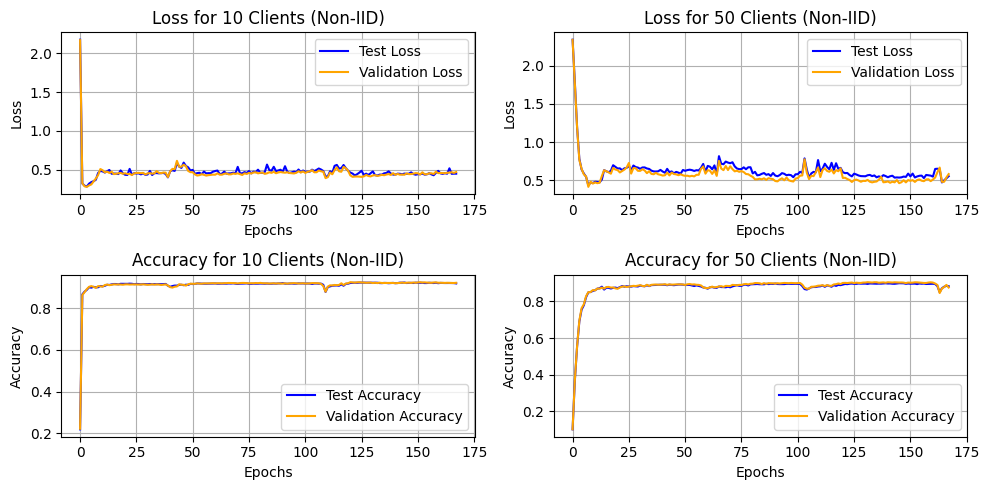

In [13]:
import matplotlib.pyplot as plt

def plot_combined_metrics(df_10, df_50):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

    # Plotting Test and Validation Loss for 10 Clients
    axes[0, 0].plot(df_10['test_avg_loss'], label='Test Loss', color='blue')
    axes[0, 0].plot(df_10['val_avg_loss'], label='Validation Loss', color='orange')
    axes[0, 0].set_title('Loss for 10 Clients (Non-IID)')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plotting Test and Validation Loss for 50 Clients
    axes[0, 1].plot(df_50['test_avg_loss'], label='Test Loss', color='blue')
    axes[0, 1].plot(df_50['val_avg_loss'], label='Validation Loss', color='orange')
    axes[0, 1].set_title('Loss for 50 Clients (Non-IID)')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plotting Test and Validation Accuracy for 10 Clients
    axes[1, 0].plot(df_10['test_avg_acc'], label='Test Accuracy', color='blue')
    axes[1, 0].plot(df_10['val_avg_acc'], label='Validation Accuracy', color='orange')
    axes[1, 0].set_title('Accuracy for 10 Clients (Non-IID)')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Plotting Test and Validation Accuracy for 50 Clients
    axes[1, 1].plot(df_50['test_avg_acc'], label='Test Accuracy', color='blue')
    axes[1, 1].plot(df_50['val_avg_acc'], label='Validation Accuracy', color='orange')
    axes[1, 1].set_title('Accuracy for 50 Clients (Non-IID)')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Assume df_10 and df_50 are already loaded and prepared as Pandas DataFrames
plot_combined_metrics(df_10, df_50)


In [14]:
# Function to calculate mean and standard deviation
def calculate_stats(df, column_name):
    mean_val = df[column_name].mean()
    std_val = df[column_name].std()
    return f"{mean_val *100:.2f} ± {std_val*100:.2f}"

# Calculate stats for both datasets
test_acc_stats_10 = calculate_stats(df_10, 'test_avg_acc')
test_acc_stats_50 = calculate_stats(df_50, 'test_avg_acc')

print("Test Accuracy for 10 Clients (Non IID): ", test_acc_stats_10)
print("Test Accuracy for 50 Clients (Non IID): ", test_acc_stats_50)

Test Accuracy for 10 Clients (Non IID):  91.34 ± 5.46
Test Accuracy for 50 Clients (Non IID):  87.43 ± 7.97
